## Instruction
In this notebook, we will complete backtest which is the last step.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import scipy
from scipy.optimize import fmin_l_bfgs_b
from sklearn.decomposition import PCA

from statistics import median
from scipy.stats import gaussian_kde
from statsmodels.formula.api import ols

from helper.project_helper import NoOverlapVoter

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 4]

import warnings
warnings.filterwarnings('ignore')

### Load Factors
We have factors store in csv file which process and combine from privious steps. Pick up backtest time from 2022.4 - 2022.3

In [2]:
universe_raw = pd.read_csv('factor_data/all_zscore_16.csv').iloc[:,1:]
universe_raw['date'] = pd.to_datetime(universe_raw['trade_date'], format='%Y%m%d')
universe = universe_raw.set_index(['date']).sort_values(by=['date'])
universe = universe.fillna(method='ffill').fillna(0.)

# only use from 2022.3 to 2023.3, here from 20220201 in order to generate risk model from history
universe = universe.loc[universe['trade_date']>=20220201]
universe.columns

Index(['ts_code', 'trade_date', 'turnover_rate', 'pe', 'pb', 'total_share',
       'free_share', 'total_mv', 'circ_mv', 'name', 'industry', 'list_date',
       'volume', 'amount', 'open', 'close', 'high', 'low', 'rsi_6', 'rsi_12',
       'ann_date', 'type', 'p_change_min', 'p_change_max', 'issue_price',
       'issue_amount', 'cfps', 'revenue_ps', 'gross_margin', 'dt_eps',
       'dt_eps_yoy', 'bps', 'bps_yoy', 'extra_item', 'profit_dedt', 'roe_dt',
       'roe_yoy', 'ebt_yoy', 'or_yoy', 'alpha_close2open', 'supertrend',
       'close_5_sma', 'turnover_rate_5_sma', 'log-ret', 'atr_6', 'ppo',
       'cci_6', 'wr_6', 'alpha_close2open_25_sma', 'close_10_kama_2_30',
       'close_10_kama_5_30', 'alpha_supertrend', 'alpha_kama', 'alpha_cci',
       'alpha_winlos', 'alpha_peg', 'alpha_turnover', 'alpha_volume',
       'alpha_ppo', 'alpha_skew2sentiment'],
      dtype='object')

In [3]:
sector_dict = {'化学制药':1, '医药商业':2, '中成药':3, '生物制药':4, '医疗保健':5}

all_factors = universe.copy(deep=True)
sector_columns = []
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = False
    sector_columns.append('sector_{}'.format(sector_i))
    
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = np.where(all_factors['industry']==sector_name, True, False)

### Add and Process AI Factor by Random Forest Model

In [4]:
import joblib

features = [ 
            'pb', 'total_share', 'cfps', 'dt_eps', 'bps', 
            'bps_yoy', 'roe_yoy', 'ebt_yoy', 'or_yoy', 'dt_eps_yoy', 'atr_6',
            'alpha_close2open_25_sma', 'alpha_supertrend', 'alpha_cci', 'alpha_kama','alpha_winlos',
            'alpha_skew2sentiment', 'alpha_peg', 'alpha_turnover', 'alpha_volume', 'alpha_ppo',
            ] #+ sector_columns

clf_load = joblib.load('AI_data/clf_16.pkl') 
alpha_score = clf_load.predict_proba(all_factors[features]).dot(np.array([-1, 0, 1]))
all_factors['alpha_AI'] = alpha_score
#all_factors['alpha_pb'] = -all_factors['pb']
print(alpha_score, len(alpha_score))

[ 0.01000576  0.0134493  -0.00630299 ...  0.03001853  0.00426392
  0.01947095] 4023


In [5]:
# zscore AI factor
from scipy.stats import zscore
all_factors[['alpha_AI_check','cfps']] = all_factors.groupby('date')[['alpha_AI','cfps']].apply(zscore).fillna(0)
all_factors = all_factors.rename({'alpha_AI' : 'AI'}, axis='columns')
all_factors = all_factors.sort_values(by=['date'])

In [6]:
features = ['ts_code', 'trade_date', 'name', 'industry', 'close', 'log-ret',
       'alpha_volume', 'alpha_ppo', 'alpha_winlos', 'AI', 'alpha_AI_check']
universe = all_factors.copy(deep=True)[features]
universe.head()

,ts_code,trade_date,name,industry,close,log-ret,alpha_volume,alpha_ppo,alpha_winlos,AI,alpha_AI_check
date,,,,,,,,,,,
2022-02-07,603368.SH,20220207,柳州医药,医药商业,16.10243,0.010293,0.334508,0.100685,-0.264539,0.010006,-0.063898
2022-02-07,300519.SZ,20220207,新光药业,中成药,17.32667,-0.007212,0.102665,0.066725,0.834581,-0.000400,-1.070208
2022-02-07,603811.SH,20220207,诚意药业,化学制药,14.69951,0.012765,-0.063367,-0.438836,0.667343,0.000186,-1.013540
2022-02-07,002864.SZ,20220207,盘龙药业,中成药,25.22598,0.003953,0.038164,0.806955,0.811375,0.001670,-0.870015
2022-02-07,003020.SZ,20220207,立方制药,化学制药,34.58645,-0.016476,0.298823,-0.888359,-0.033021,0.008231,-0.235509


In [7]:
## fill data to history by 0 in order to get same init holding size
def init_holding(df):
    ticker_list = df.ts_code.unique()
    calendar = df.trade_date.unique()
    for dt in tqdm(calendar):
        day_df = df.loc[df.trade_date == dt]
        diff_tickers = list(set(ticker_list) - set(day_df.ts_code.unique()))
        if len(diff_tickers) > 0:
            for ticker in diff_tickers:
                check_df = df.loc[df.ts_code==ticker].iloc[0,:]
                data = [pd.to_datetime(dt, format='%Y%m%d'), ticker, dt, check_df['name'],
                        check_df['industry'], 0., 0., 0., 0., 0., 0., 0.]
                data = pd.DataFrame(data=data, index=np.append(['date'], df.columns)).T.set_index(['date'])
                df = df.append(data)
    df = df.sort_values(by=['date']) 
    return df

universe = init_holding(universe)

100%|████████████████████████████████████████| 278/278 [00:02<00:00, 124.52it/s]


In [8]:
universe.head()

,ts_code,trade_date,name,industry,close,log-ret,alpha_volume,alpha_ppo,alpha_winlos,AI,alpha_AI_check
date,,,,,,,,,,,
2022-02-07,603368.SH,20220207,柳州医药,医药商业,16.10243,0.010293,0.334508,0.100685,-0.264539,0.010006,-0.063898
2022-02-07,688358.SH,20220207,祥生医疗,医疗保健,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-07,688117.SH,20220207,圣诺生物,生物制药,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-07,002923.SZ,20220207,润都股份,化学制药,15.60073,0.007774,0.636176,2.316453,0.574776,0.03011,1.880287
2022-02-07,605177.SH,20220207,东亚药业,化学制药,24.2071,0.00822,0.417342,0.374641,-2.015148,0.013449,0.269106


### Factor Exposures and Factor Returns
The facort values in cross section should view as a type of exposure. We can calculate factor returns bettwen exposures of each ticker and daily return. We also did this in backtestig animate notebook.

In [9]:
## shif return 2 times
all_factors = universe.copy(deep=True)
all_factors = all_factors.sort_values(by=['date'])
all_factors = all_factors.replace([np.inf, -np.inf], np.nan).fillna(0.)
all_factors['returns_2'] = all_factors.groupby('ts_code')['log-ret'].shift(-5).fillna(method='ffill')

## lean data
#all_factors = all_factors.replace([np.inf, -np.inf], np.nan)
#all_factors = all_factors[~all_factors.isin([np.nan, np.inf, -np.inf]).any(1)]
#all_factors.reset_index(inplace=True)
#all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
#all_factors = all_factors.set_index(['date']).sort_values(by=['date'])

print(universe.shape, all_factors.shape)

(4448, 11) (4448, 12)


In [10]:
def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n, name):
    return list(filter(lambda x: name in x, n))

def estimate_factor_returns(df, name='alpha_'): 
    ## winsorize returns for fitting 
    estu = df.copy(deep=True)
    estu['returns_2'] = wins(estu['returns_2'], -0.2, 0.2)
    all_factors = factors_from_names(list(df), name)
    form = get_formula(all_factors, "returns_2")
    model = ols(form, data=estu)
    results = model.fit()
    return results

estimate_factor_returns(all_factors.loc[all_factors['trade_date']==20220505]).params

alpha_volume     -0.008698
alpha_ppo         0.003493
alpha_winlos     -0.010093
alpha_AI_check   -0.011536
dtype: float64

In [11]:
calendar = all_factors.trade_date.unique() # int64
facret = {}
for dt in tqdm(calendar, desc='regression factor returns'):
    facret[dt] = estimate_factor_returns(all_factors.loc[all_factors['trade_date']==dt]).params
facret[calendar[-1]]

regression factor returns: 100%|██████████████| 278/278 [00:03<00:00, 88.97it/s]


alpha_volume     -3.252607e-19
alpha_ppo         8.131516e-20
alpha_winlos     -3.252607e-19
alpha_AI_check    2.710505e-19
dtype: float64

#### Veiw Factor Returns

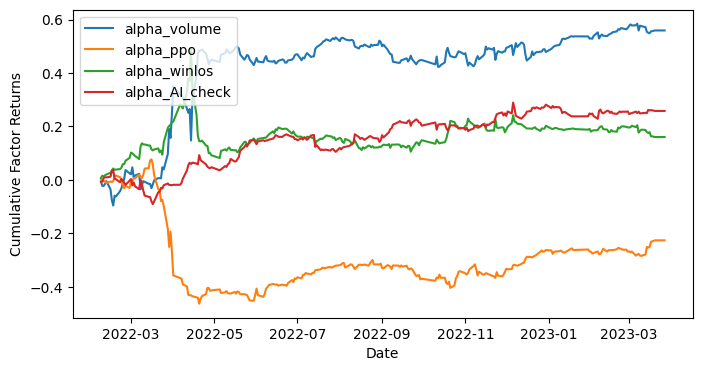

In [12]:
date_list = all_factors.index.unique()
facret_df = pd.DataFrame(index = date_list)
alpha_field = factors_from_names(list(all_factors), 'alpha_')

for ii, dt in zip(calendar,date_list): 
    for alp in alpha_field: 
        facret_df.at[dt, alp] = facret[ii][alp]

for column in facret_df.columns:
    if column != 'alpha_AI':
        plt.plot(facret_df[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

### PCA model
We use PCA algorithm to estimate risk

In [13]:
from sklearn.decomposition import PCA

class RiskModel(object):
    def __init__(self, returns, num_factor_exposures, ann_factor=252):
        
        self.num_factor_exposures = num_factor_exposures
        self.pca = PCA(n_components=num_factor_exposures, svd_solver='full')
        self.pca.fit(returns)
        
        self.factor_betas_ = self.factor_betas(self.pca, returns.columns.values, np.arange(num_factor_exposures))
        self.factor_returns_ = self.factor_returns(self.pca, returns, returns.index, np.arange(num_factor_exposures))
        self.factor_cov_matrix_ = self.factor_cov_matrix(self.factor_returns_, ann_factor)
        
        self.idiosyncratic_var_matrix_ = self.idiosyncratic_var_matrix(returns, 
                                            self.factor_returns_, self.factor_betas_, ann_factor)
        self.idiosyncratic_var_vector = pd.DataFrame(data=np.diag(self.idiosyncratic_var_matrix_),
                                                     index=returns.columns)
    
    # got new exposure expressed by pca model
    def factor_betas(self, pca, factor_beta_indices, factor_beta_columns):
        return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)
    
    # got new factor returns expressed by pca model
    def factor_returns(self, pca, returns, factor_return_indices, factor_return_columns):
        return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)
    
    # got new factor covariance matirx by pca expressed returns
    def factor_cov_matrix(self, factor_returns, ann_factor):
        return np.diag(factor_returns.var(axis=0, ddof=1) * ann_factor)
    
    # calculate idiosyncratic need to got factor_returns, factor_betas which calculate by pca model first
    def idiosyncratic_var_matrix(self, returns, factor_returns, factor_betas, ann_factor):
        estimate_returns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
        residuals = returns - estimate_returns
        return pd.DataFrame(np.diag(np.var(residuals))*ann_factor, returns.columns, returns.columns)
    
    def plot_principle_risk(self):
        # Make the bar plot
        plt.bar(np.arange(self.num_factor_exposures), self.pca.explained_variance_ratio_)

In [14]:
def rolling_df_by_day(df, start_time):
    pca_time_window = len(df.loc[df['trade_date']<start_time].trade_date.unique())
    print(f'pca window_len is {pca_time_window}')
    #trade_date_list = df.loc[df['trade_date']>=start_time].trade_date.unique()
    all_date_list = df.trade_date.unique()
    for start_i in range(len(all_date_list)):
        start_date = all_date_list[start_i]
        if start_i + pca_time_window >= len(all_date_list):
            break
        end_date = all_date_list[start_i + pca_time_window]
        yield end_date, df.loc[(df['trade_date']>=start_date) & (df['trade_date']<=end_date)]
        
def risk_by_PCA(returns_df):
    # Set the number of factor exposures (principal components) for the PCA algorithm
    num_factor_exposures = 1
    # Create a RiskModel object
    rm = RiskModel(returns_df, num_factor_exposures)
    
    B = rm.factor_betas_
    F = rm.factor_cov_matrix_
    S = rm.idiosyncratic_var_matrix_
    f = rm.factor_returns_
    
    variance = np.dot(B, F).dot(B.T) + S
    return variance, B, f, rm.idiosyncratic_var_vector

# test
start_time = 20220301
dt, df = next(rolling_df_by_day(all_factors, start_time))
returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
variance_i, B, risk_factor, residual_i = risk_by_PCA(returns_df)
df.loc[df.index[-1],'trade_date'].unique()[-1]
print(f'return date {dt}')
variance_i.head()

pca window_len is 16
return date 20220301


ts_code,002462.SZ,002864.SZ,002873.SZ,002923.SZ,002940.SZ,003020.SZ,300519.SZ,300639.SZ,600750.SH,603368.SH,603538.SH,603811.SH,605177.SH,688117.SH,688358.SH,688799.SH
ts_code,,,,,,,,,,,,,,,,
002462.SZ,0.066984,0.019427,0.072102,0.010668,0.018067,0.043551,0.025587,0.018246,0.017640,0.019501,0.023480,0.026623,0.012787,0.0,0.0,0.0
002864.SZ,0.019427,0.074620,0.208218,0.030806,0.052174,0.125768,0.073890,0.052690,0.050940,0.056314,0.067807,0.076882,0.036926,0.0,0.0,0.0
002873.SZ,0.072102,0.208218,1.021662,0.114334,0.193638,0.466778,0.274236,0.195555,0.189061,0.209006,0.251658,0.285341,0.137048,0.0,0.0,0.0
002923.SZ,0.010668,0.030806,0.114334,0.123901,0.028649,0.069060,0.040574,0.028933,0.027972,0.030923,0.037233,0.042217,0.020276,0.0,0.0,0.0
002940.SZ,0.018067,0.052174,0.193638,0.028649,0.260697,0.116962,0.068716,0.049001,0.047373,0.052371,0.063059,0.071499,0.034341,0.0,0.0,0.0


In [15]:
start_time = 20220301
variance_all = {}
residual_df = pd.DataFrame()

for dt, df in rolling_df_by_day(all_factors, start_time):
    ticker_list = all_factors.loc[all_factors.trade_date==dt].ts_code.unique()
    df = df.loc[df.ts_code.isin(ticker_list)]
    returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
    variance_i, B, risk_factor, residual_i = risk_by_PCA(returns_df)
    variance_all[dt] = [variance_i, B, risk_factor.mean(axis=0)]
    residual_i['trade_date'] = df.loc[df.index[-1],'trade_date'].unique()[-1]
    residual_df = residual_df.append(residual_i)

residual_df.reset_index(inplace=True)
residual_df.columns = ['ts_code', 'residual', 'trade_date']
residual_df['residual'] = np.where(residual_df['residual'].isnull(), residual_df['residual'].median(), residual_df['residual'])
all_factors = all_factors.loc[all_factors['trade_date']>=start_time]
all_factors = all_factors.merge(residual_df, on=['trade_date','ts_code'], how='left')
#all_factors.tail()
print(residual_df.shape, all_factors.shape)

pca window_len is 16
(4192, 3) (4192, 13)


### Combine AlphaFactors

In [18]:
print(max(all_factors['alpha_volume']), min(all_factors['alpha_volume']))
print(max(all_factors['alpha_winlos']), min(all_factors['alpha_winlos']))
print(max(all_factors['alpha_ppo']), min(all_factors['alpha_ppo']))
print(max(all_factors['AI']), min(all_factors['AI']))

1.191500517160925 -3.8516548101056753
3.632264924190442 -3.7521151923065656
2.832023326360194 -3.191037612384312
0.03878663047567388 -0.012582174616273978


In [20]:
all_factors['alpha_volume'] = wins(all_factors['alpha_volume'], -all_factors['alpha_volume'].max(), all_factors['alpha_volume'].max())
all_factors['alpha_winlos'] = wins(all_factors['alpha_winlos'], -all_factors['alpha_winlos'].max(), all_factors['alpha_winlos'].max())
all_factors['alpha_ppo'] = wins(all_factors['alpha_ppo'], -all_factors['alpha_ppo'].max(), all_factors['alpha_ppo'].max())
all_factors['AI'] = wins(all_factors['AI'], -all_factors['AI'].max(), all_factors['AI'].max())



In [22]:
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
all_factors['alpha_AI'] = all_factors['AI']
alpha_df = all_factors.drop(columns=['returns_2']).set_index(['date', 'ts_code'])

alpha_df['alpha_all'] = (0.3 * alpha_df['alpha_AI'] / alpha_df['alpha_AI'].max()
                         + 0.4*alpha_df['alpha_volume'] / alpha_df['alpha_volume'].max() 
                         + 0.01*alpha_df['alpha_ppo'] / alpha_df['alpha_ppo'].max()
                         + 0.2*alpha_df['alpha_winlos'] / alpha_df['alpha_winlos'].max())
print(max(alpha_df['alpha_all']), min(alpha_df['alpha_all']))
alpha_df['alpha_all'] = alpha_df['alpha_all']/max(abs(alpha_df['alpha_all']))
print(max(alpha_df['alpha_all']), min(alpha_df['alpha_all']))

0.635393279636352 -0.6462892969450225
0.9831406502317531 -1.0


### Backtesting

In [23]:
# the lambda expressed a transfer costs can't endure, the larger the more we reject.
def get_obj_func(h0, variance, alpha, Lambda=3e-3, aversion=2): 
    def obj_func(h):
        #f = 0.5 * aversion * np.dot(h, variance).dot(h.T) - aversion * np.matmul(h, alpha) + np.dot((h-h0)**2, Lambda)
        f =  - np.matmul(h, alpha) \
             + 0.5 * aversion * np.dot(h, variance).dot(h.T) \
             + Lambda * abs((h-h0))
        return f
    return obj_func

def get_grad_func(h0, variance, alpha, Lambda=3e-3, aversion=2):
    def grad_func(h):
        #f_hat =  aversion * np.dot(variance, h) - aversion * alpha + 2 * Lambda * (h-h0)
        f_hat =  - alpha  \
                + aversion * np.dot(variance, h) \
                + Lambda
        return f_hat
    return grad_func

# bounds means position bounds at each row. Here I only trade for long so that bounds from 0 to 1

#start_time = 20220315
alpha_df['h_privious'] = 0.
positions = {}
calendar = alpha_df.trade_date.unique()

# get parameter
ticker_num = len(alpha_df.index.get_level_values(1).unique())
h0 = [0.] * ticker_num
bounds = [(0,1)] * ticker_num

for dt in calendar:
    # fill yesterday holding
    obj_df = alpha_df.loc[alpha_df.trade_date==dt]
    
    # convex optimize
    obj_func = get_obj_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
    grad_func = get_grad_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
    h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func, bounds=bounds)
    #h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func)
    
    # update optimize holding
    obj_df['h_opt'] = h_optimal
    obj_df['h_privious'] = h0
    positions[dt]= obj_df
    h0 = h_optimal
    

10.206274376029132 1.4858572849881582


<AxesSubplot:>

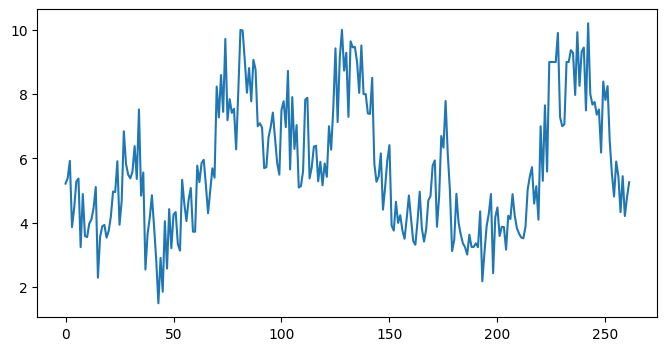

In [24]:
all_positions = []
for dt in positions.keys():
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))
#positions[20230315]['h_opt'].hist()
pd.Series(all_positions).plot()

In [25]:
for i in positions.keys():
    positions[i]['h_opt'] = positions[i]['h_opt']/(positions[i]['h_opt'].sum()+1e-5)
    positions[i]['h_privious'] = positions[i]['h_privious']/(positions[i]['h_privious'].sum()+1e-5)
h_optimal_list = [positions[dt]['h_opt'] for dt in positions.keys() ]
h_privious_list = [positions[dt]['h_privious'] for dt in positions.keys() ]

0.999999020211506 0.9999932699238343


<AxesSubplot:>

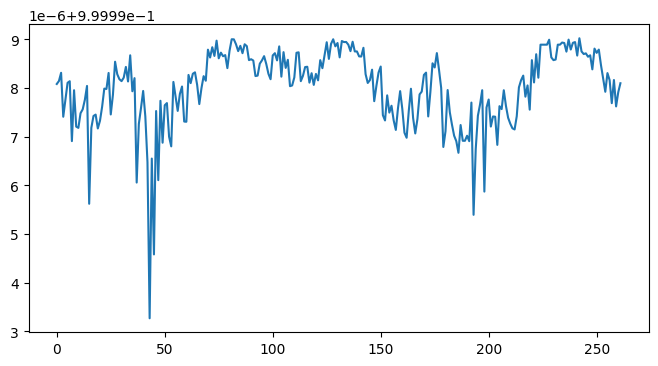

In [26]:
all_positions = []
for dt in positions.keys():
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))
#positions[20230315]['h_opt'].hist()
pd.Series(all_positions).plot()

## Calculate Exposure and Transaction Costs

### risk exposure
We use pca to calculate risk, so we can view residual(alpha) as risk exposure.

<AxesSubplot:title={'center':'Risk Exposure'}>

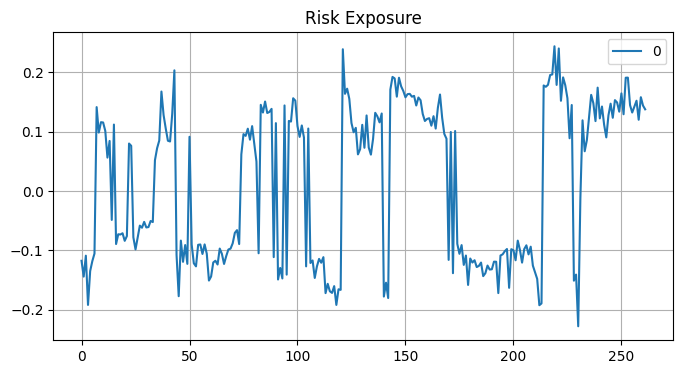

In [27]:
#plt.rcParams['figure.figsize'] = [7, 3]
risk_exposures_df = pd.DataFrame()
risk_exposures = {}
for ii, dt in enumerate(positions.keys()):
    B = variance_all[dt][1]
    h_opt_i = h_optimal_list[ii]
    risk_exposure = np.matmul(h_opt_i.T, B)
    risk_exposures[dt] = risk_exposure
    risk_exposures_df = risk_exposures_df.append(risk_exposure, ignore_index=True)

#np.sum(risk_exposures)
risk_exposures_df.plot(grid=True, title='Risk Exposure')
#risk_exposures_df.head()

### alpha exposure

<AxesSubplot:>

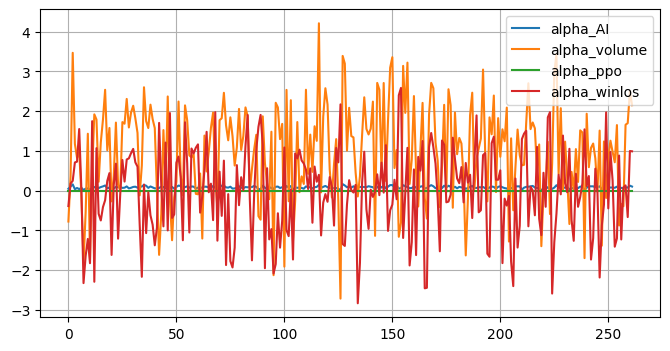

In [29]:
import patsy
import pandas

def colnames(B):
    if type(B) == patsy.design_info.DesignMatrix: 
        return B.design_info.column_names
    if type(B) == pandas.core.frame.DataFrame: 
        return B.columns.tolist()
    return None

def get_B_alpha(universe):
    alpha_factors = factors_from_names(list(universe),'alpha')
    formula = get_formula(alpha_factors, "returns_2")
    outcome, B_alpha = patsy.dmatrices(formula, universe)
    return B_alpha

alpha_df_ = alpha_df.merge(all_factors[['trade_date','ts_code','returns_2']], on=['trade_date','ts_code'], how='left')
calendar = alpha_df.trade_date.unique()
alpha_exposure_df = pd.DataFrame()
alpha_exposures = {}
for dt in calendar:
    alpha_df_i = alpha_df_.loc[alpha_df_.trade_date==dt][['trade_date','ts_code','alpha_AI', 'alpha_volume', 'alpha_ppo', 'alpha_winlos' ,'returns_2']]
    h_opt_i = h_privious_list[ii]
    B_alpha = get_B_alpha(alpha_df_i)
    # divide 2 almost close to max(alpha_df['alpha_all'])
    
    B_alpha = B_alpha * [[0.4, 0.4, 0.0, 0.2]] * len(alpha_df_.ts_code.unique())
    #alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=colnames(B_alpha))
    alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=['alpha_AI', 'alpha_volume', 'alpha_ppo', 'alpha_winlos'])
    alpha_exposures[dt] = alpha_exposure
    alpha_exposure_df = pd.concat([alpha_exposure_df,alpha_exposure], axis=1)

alpha_exposure_df = alpha_exposure_df.T.reset_index(drop=True)
alpha_exposure_df.plot(grid=True)

### Transaction Costs

In [30]:
transaction_costs = []
Lambda = 3e-3
for i in range(len(h_optimal_list)):
    tmp_change = h_optimal_list[i] - h_privious_list[i]
    costs = sum(np.dot(tmp_change.values**2, Lambda))
    transaction_costs.append(costs)
print(sum(transaction_costs))

0.12950739644259426


## Profit-and-Loss (PnL) 

In [31]:
#all_factors.head()
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
all_factors = all_factors.set_index(['date']).sort_values(by=['date'])

In [32]:
all_factors.index.unique()[0]

Timestamp('2022-03-01 00:00:00')

2023-03-27 00:00:00


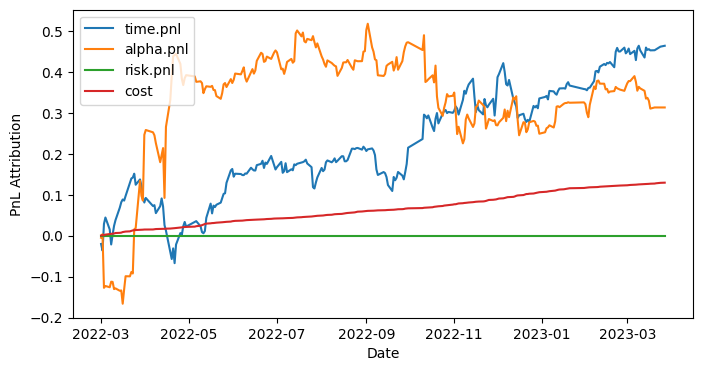

In [33]:
## assumes v, w are pandas Series 
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

def build_pnl_attribution(): 

    df = pd.DataFrame(index = pd.to_datetime(all_factors['trade_date'].unique(), format='%Y%m%d'))
    calendar = all_factors.trade_date.unique()
    counter = range(len(calendar))
    for ii, dt, time_i in zip(counter,calendar,df.index):
        # holding frame
        p = positions[dt]
        # alpha f
        fr = facret[dt]#[[0,2,5]]
        # risk f
        rr = variance_all[dt][2]
        row_universe = all_factors.loc[all_factors.trade_date==dt]
        mf = p[['h_privious', 'h_opt']].merge(row_universe[['ts_code', 'returns_2']], how = 'left', on = "ts_code")  
        mf['returns_2'] = wins(mf['returns_2'], -0.2, 0.2)
        df.at[time_i,"time.pnl"] = np.sum(mf['h_opt'] * mf['returns_2'])
        df.at[time_i,"alpha.pnl"] = partial_dot_product(fr, alpha_exposures[dt])
        df.at[time_i,"risk.pnl"] = partial_dot_product(rr, risk_exposures[dt])
        df.at[time_i,"cost"] = transaction_costs[ii]
    
    print(time_i)
    return df

attr = build_pnl_attribution()
for column in attr.columns:
    plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

In [34]:
facret[dt]
#alpha_exposures[dt]

alpha_volume     -3.252607e-19
alpha_ppo         8.131516e-20
alpha_winlos     -3.252607e-19
alpha_AI_check    2.710505e-19
dtype: float64

In [35]:
attr['time.pnl'].sum()

0.46393470866745196

In [51]:
def build_portfolio_characteristics(): 
    df = pd.DataFrame(index = pd.to_datetime(all_factors['trade_date'].unique(), format='%Y%m%d'))
    calendar = all_factors.trade_date.unique()
    for ii,dt in zip(calendar, df.index):
        p = positions[ii]

        df.at[dt,"long"] = np.sum([_ for _ in p['h_opt'] if _ > 0])
        # df.at[dt,"short"] = np.sum([_ for _ in h if _ < 0])
        df.at[dt,"net"] = np.sum(p['h_opt'])
        df.at[dt,"gmv"] = np.sum(abs(p['h_opt']))
        df.at[dt,"traded"] = np.sum(abs(p['h_opt'] - p['h_privious']))
        
    return df

In [ ]:
pchar = build_portfolio_characteristics()
print(pchar.tail())
for column in pchar.columns:
        plt.plot(pchar[column], label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Portfolio')
plt.show()